In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 99% 605M/612M [00:09<00:00, 84.7MB/s]
100% 612M/612M [00:09<00:00, 68.4MB/s]


In [ ]:
! unzip /content/drive/MyDrive/Traffic_signature/archive.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054

In [ ]:
%pwd

'/content'

In [27]:
import os, time, sys
os.environ['KERAS_BACKEND'] = 'torch'
import csv
import math, random
from PIL import Image
import cv2
import imageio
import keras



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform

from importlib import reload

import pwk as pwk

import my_loader as my_loader
import my_models as my_models
import my_tools  as my_tools
from my_TensorboardCallback import TensorboardCallback


Module my_loader loaded.
Module my_models loaded.


In [28]:
scale = 0.1
output_dir = './data'

In [29]:
df = pd.read_csv('Test.csv', header=0)
display(df.head(10))

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
5,52,56,5,5,47,51,38,Test/00005.png
6,147,130,12,12,135,119,18,Test/00006.png
7,32,33,5,5,26,28,12,Test/00007.png
8,45,50,6,5,40,45,25,Test/00008.png
9,81,86,7,7,74,79,35,Test/00009.png


In [30]:
def  read_csv_dataset(csv_file):
    '''
    Reads traffic sign data from German Traffic Sign Recognition Benchmark dataset.
    Arguments:
        csv filename :  Description file, Example Train.csv
    Returns:
        x,y          :  np array of images, np array of corresponding labels
    '''

    path = os.path.dirname(csv_file)
    name = os.path.basename(csv_file)

    # ---- Read csv file
    #
    df = pd.read_csv(csv_file, header=0)

    # ---- Get filenames and ClassIds
    #
    filenames = df['Path'].to_list()
    y         = df['ClassId'].to_list()
    x         = []

    # ---- Read images
    #
    for filename in filenames:
        image = io.imread(f'{filename}')
        x.append(image)
        pwk.update_progress(name,len(x),len(filenames))

    # ---- Return
    #
    return np.array(x,dtype=object),np.array(y)

In [31]:
pwk.chrono_start()

# ---- Read datasets

(x_train,y_train) = read_csv_dataset('Train.csv')
(x_test ,y_test)  = read_csv_dataset('Test.csv')
(x_meta ,y_meta)  = read_csv_dataset('Meta.csv')

# ---- Shuffle train set

x_train, y_train = pwk.shuffle_np_dataset(x_train, y_train)

# ---- Sort Meta

combined = list(zip(x_meta,y_meta))
combined.sort(key=lambda x: x[1])
x_meta,y_meta = zip(*combined)

pwk.chrono_show()

Train.csv        [########################################] 100.0% of 39209
Test.csv         [########################################] 100.0% of 12630
Meta.csv         [########################################] 100.0% of 43

Duration :  00:00:41 555ms


In [32]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly,lz) = image.shape
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly,lz) = image.shape
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)

x_train shape :  (39209,)
y_train shape :  (39209,)
x_test  shape :  (12630,)
y_test  shape :  (12630,)


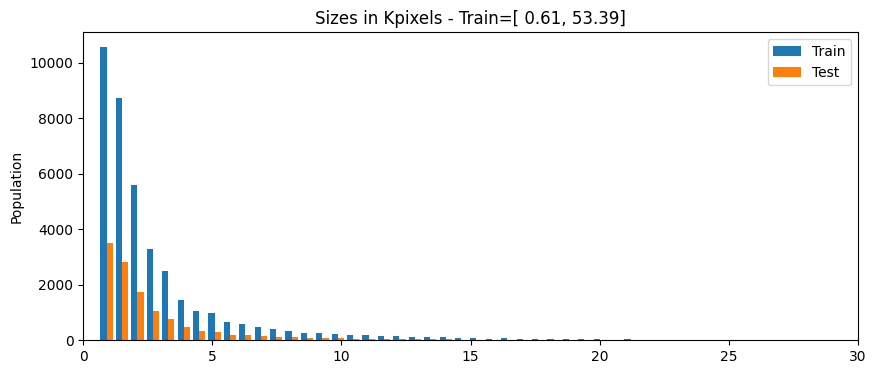

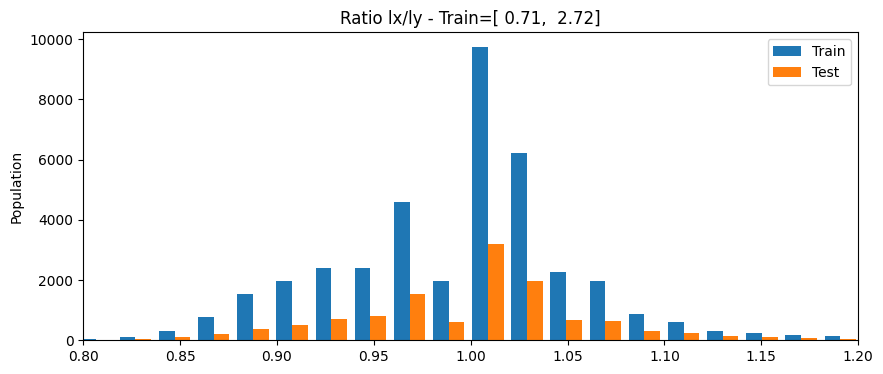

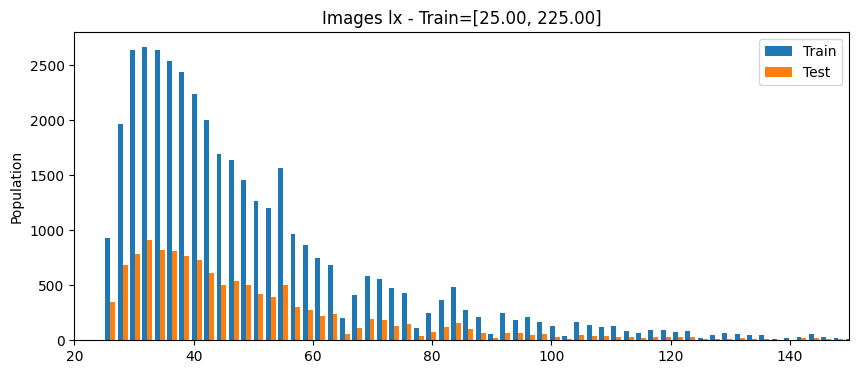

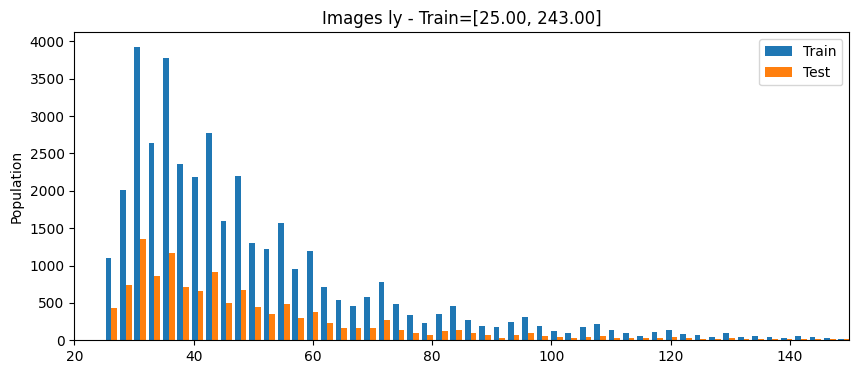

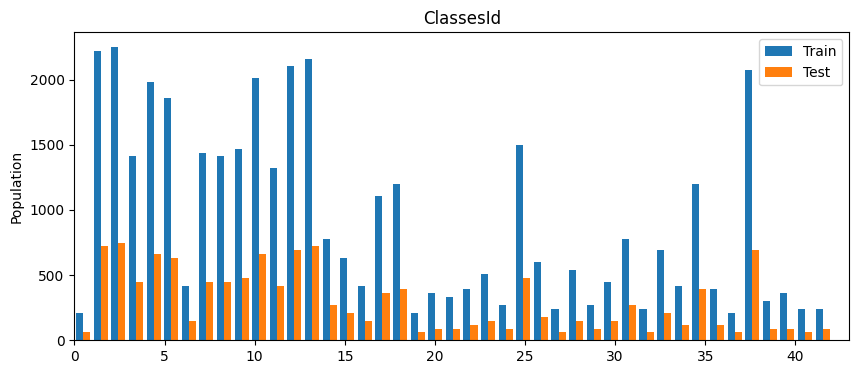

In [33]:
figsize=(10,4)
# ------ Global stuff
print("x_train shape : ",x_train.shape)
print("y_train shape : ",y_train.shape)
print("x_test  shape : ",x_test.shape)
print("y_test  shape : ",y_test.shape)

# ------ Statistics / sizes
plt.figure(figsize=figsize)
plt.hist([train_size,test_size], bins=100)
plt.gca().set(title='Sizes in Kpixels - Train=[{:5.2f}, {:5.2f}]'.format(min(train_size),max(train_size)),
              ylabel='Population', xlim=[0,30])
plt.legend(['Train','Test'])
pwk.save_fig('01-stats-sizes')
plt.show()

# ------ Statistics / ratio lx/ly
plt.figure(figsize=figsize)
plt.hist([train_ratio,test_ratio], bins=100)
plt.gca().set(title='Ratio lx/ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ratio),max(train_ratio)),
              ylabel='Population', xlim=[0.8,1.2])
plt.legend(['Train','Test'])
pwk.save_fig('02-stats-ratios')
plt.show()

# ------ Statistics / lx
plt.figure(figsize=figsize)
plt.hist([train_lx,test_lx], bins=100)
plt.gca().set(title='Images lx - Train=[{:5.2f}, {:5.2f}]'.format(min(train_lx),max(train_lx)),
              ylabel='Population', xlim=[20,150])
plt.legend(['Train','Test'])
pwk.save_fig('03-stats-lx')
plt.show()

# ------ Statistics / ly
plt.figure(figsize=figsize)
plt.hist([train_ly,test_ly], bins=100)
plt.gca().set(title='Images ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ly),max(train_ly)),
              ylabel='Population', xlim=[20,150])
plt.legend(['Train','Test'])
pwk.save_fig('04-stats-ly')
plt.show()

# ------ Statistics / classId
plt.figure(figsize=figsize)
plt.hist([y_train,y_test], bins=43)
plt.gca().set(title='ClassesId', ylabel='Population', xlim=[0,43])
plt.legend(['Train','Test'])
pwk.save_fig('05-stats-classes')
plt.show()

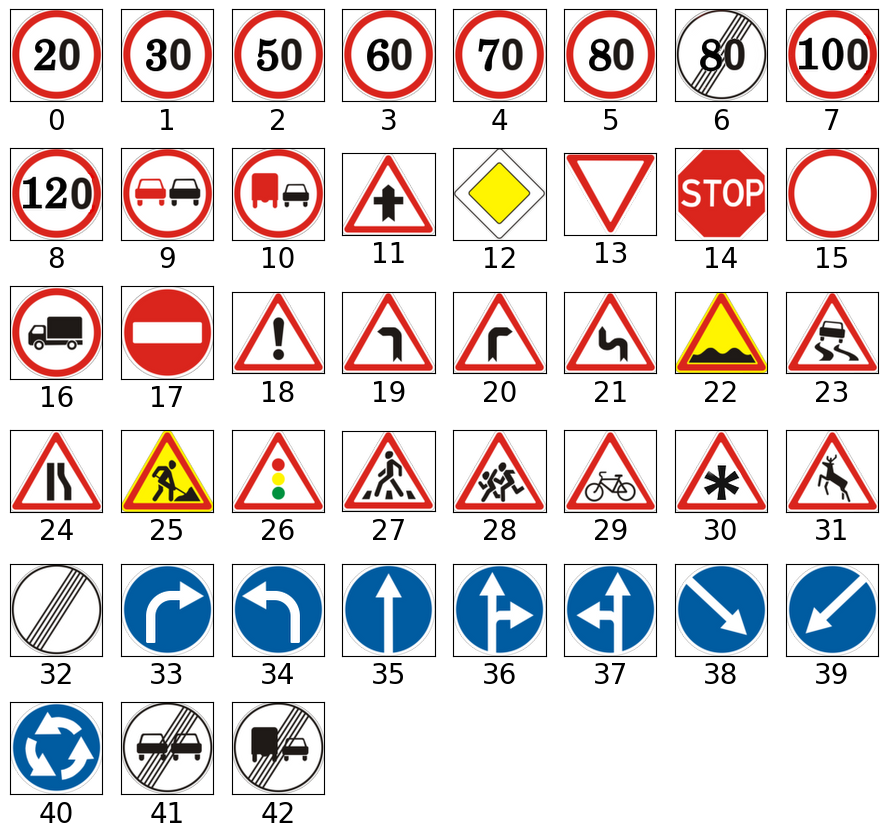

In [34]:
pwk.plot_images( x_meta,y_meta, range(43), columns=8, x_size=1.4, y_size=1.4,
                       colorbar=False, y_pred=None, cm='binary', save_as='06-meta-signs')

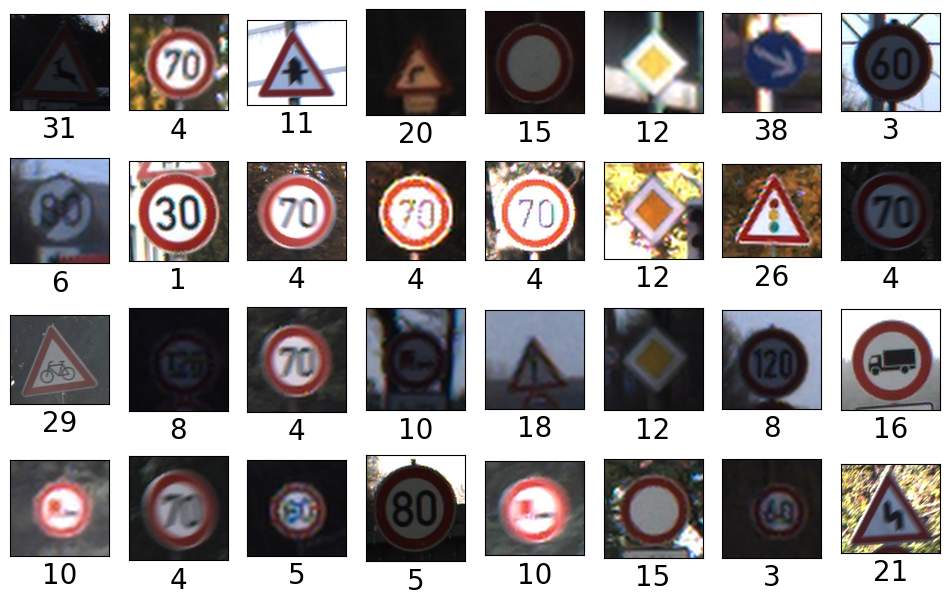

In [35]:
# ---- Get and show few images

samples = [ random.randint(0,len(x_train)-1) for i in range(32)]
pwk.plot_images( x_train,y_train, samples, columns=8, x_size=1.5, y_size=1.5,
                       colorbar=False, y_pred=None, cm='binary', save_as='07-real-signs')

In [36]:
def images_enhancement(images, width=25, height=25, proc='RGB'):
    '''
    Resize and convert images - doesn't change originals.
    input images must be RGBA or RGB.
    Note : all outputs are fixed size numpy array of float32
    args:
        images :         images list
        width,height :   new images size (25,25)
        mode :           RGB | RGB-HE | L | L-HE | L-LHE | L-CLAHE
    return:
        numpy array of enhanced images
    '''
    lz={ 'RGB':3, 'RGB-HE':3, 'L':1, 'L-HE':1, 'L-LHE':1, 'L-CLAHE':1}[proc]

    out=[]
    for img in images:

        # ---- if RGBA, convert to RGB
        if img.shape[2]==4:
            img=color.rgba2rgb(img)

        # ---- Resize
        img = transform.resize(img, (width,height))

        # ---- RGB / Histogram Equalization
        if proc=='RGB-HE':
            hsv = color.rgb2hsv(img.reshape(width,height,3))
            hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
            img = color.hsv2rgb(hsv)

        # ---- Grayscale
        if proc=='L':
            img=color.rgb2gray(img)

        # ---- Grayscale / Histogram Equalization
        if proc=='L-HE':
            img=color.rgb2gray(img)
            img=exposure.equalize_hist(img)

        # ---- Grayscale / Local Histogram Equalization
        if proc=='L-LHE':
            img=color.rgb2gray(img)
            img = img_as_ubyte(img)
            img=rank.equalize(img, disk(10))/255.

        # ---- Grayscale / Contrast Limited Adaptive Histogram Equalization (CLAHE)
        if proc=='L-CLAHE':
            img=color.rgb2gray(img)
            img=exposure.equalize_adapthist(img)

        # ---- Add image in list of list
        out.append(img)
        pwk.update_progress('Enhancement: ',len(out),len(images))

    # ---- Reshape images
    #     (-1, width,height,1) for L
    #     (-1, width,height,3) for RGB
    #
    out = np.array(out,dtype='float32')
    out = out.reshape(-1,width,height,lz)
    return out

Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16


<br>**EXPECTED**

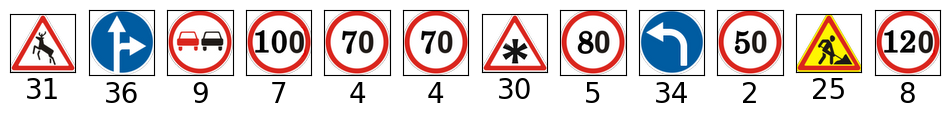

<br>**ORIGINAL**

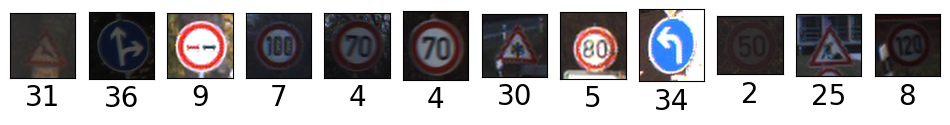

<br>**ENHANCED**

dataset : RGB  min,max=[0.030,1.000]  shape=(16, 25, 25, 3)


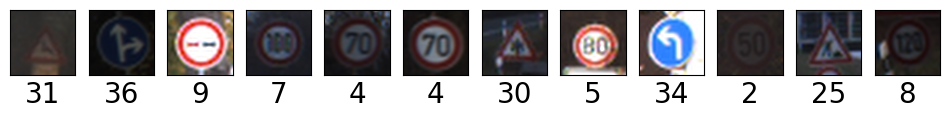

dataset : RGB-HE  min,max=[0.001,1.000]  shape=(16, 25, 25, 3)


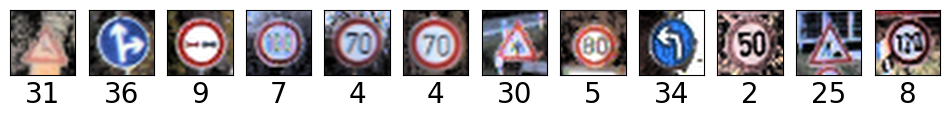

dataset : L  min,max=[0.032,1.000]  shape=(16, 25, 25, 1)


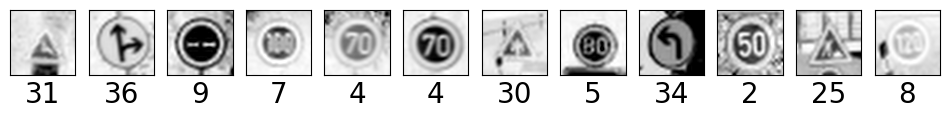

dataset : L-HE  min,max=[0.002,1.000]  shape=(16, 25, 25, 1)


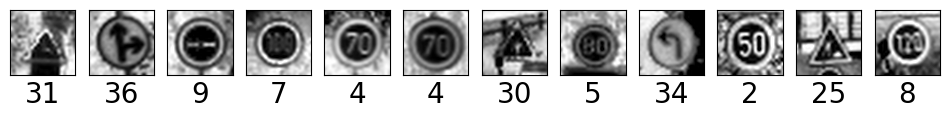

dataset : L-LHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


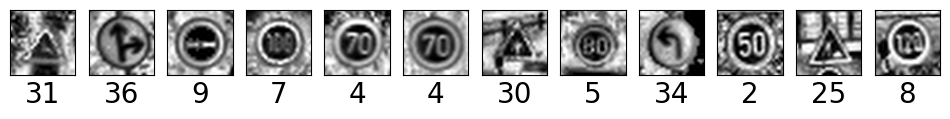

dataset : L-CLAHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


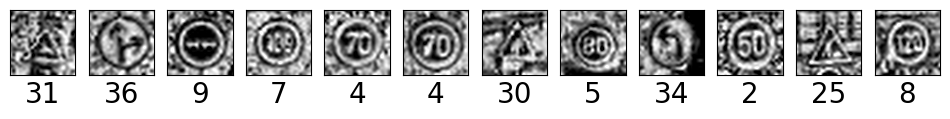

In [37]:
i=random.randint(0,len(x_train)-16)
x_samples = x_train[i:i+16]
y_samples = y_train[i:i+16]

datasets  = {}

datasets['RGB']      = images_enhancement( x_samples, width=25, height=25, proc='RGB'  )
datasets['RGB-HE']   = images_enhancement( x_samples, width=25, height=25, proc='RGB-HE'  )
datasets['L']        = images_enhancement( x_samples, width=25, height=25, proc='L'  )
datasets['L-HE']     = images_enhancement( x_samples, width=25, height=25, proc='L-HE'  )
datasets['L-LHE']    = images_enhancement( x_samples, width=25, height=25, proc='L-LHE'  )
datasets['L-CLAHE']  = images_enhancement( x_samples, width=25, height=25, proc='L-CLAHE'  )

pwk.subtitle('EXPECTED')
x_expected=[ x_meta[i] for i in y_samples]
pwk.plot_images(x_expected, y_samples, range(12), columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', save_as='08-expected')

pwk.subtitle('ORIGINAL')
pwk.plot_images(x_samples,  y_samples, range(12), columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', save_as='09-original')

pwk.subtitle('ENHANCED')
n=10
for k,d in datasets.items():
    print("dataset : {}  min,max=[{:.3f},{:.3f}]  shape={}".format(k,d.min(),d.max(), d.shape))
    pwk.plot_images(d, y_samples, range(12), columns=12, x_size=1, y_size=1,
                    colorbar=False, y_pred=None, cm='binary', save_as=f'{n}-enhanced-{k}')
    n+=1

In [38]:
def save_h5_dataset(x_train, y_train, x_test, y_test, x_meta,y_meta, filename):

    # ---- Create h5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_test",  data=x_test)
        f.create_dataset("y_test",  data=y_test)
        f.create_dataset("x_meta",  data=x_meta)
        f.create_dataset("y_meta",  data=y_meta)

    # ---- done
    size=os.path.getsize(filename)/(1024*1024)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)'.format(filename, str(x_train.shape),size))

In [39]:
# ---- Size and processings
#
all_size= [24, 48]
all_proc=['RGB', 'RGB-HE', 'L', 'L-LHE']

# ---- Do it
#
pwk.chrono_start()

n_train = int( len(x_train)*scale )
n_test  = int( len(x_test)*scale )

pwk.subtitle('Parameters :')
print(f'Scale is : {scale}')
print(f'x_train length is : {n_train}')
print(f'x_test  length is : {n_test}')
print(f'output dir is     : {output_dir}\n')

pwk.subtitle('Running...')

pwk.mkdir(output_dir)

for s in all_size:
    for m in all_proc:
        # ---- A nice dataset name
        filename = f'{output_dir}/set-{s}x{s}-{m}.h5'
        pwk.subtitle(f'Dataset : {filename}')

        # ---- Enhancement
        #      Note : x_train is a numpy array of python objects (images with <> sizes)
        #             but images_enhancement() return a real array of float64 numpy (images with same size)
        #             so, we can save it in nice h5 files
        #
        x_train_new = images_enhancement( x_train[:n_train], width=s, height=s, proc=m )
        x_test_new  = images_enhancement( x_test[:n_test],   width=s, height=s, proc=m )
        x_meta_new  = images_enhancement( x_meta,            width=s, height=s, proc='RGB' )

        # ---- Save
        save_h5_dataset( x_train_new, y_train[:n_train], x_test_new, y_test[:n_test], x_meta_new,y_meta, filename)

x_train_new,x_test_new=0,0

print('\nDone.')
pwk.chrono_show()

<br>**Parameters :**

Scale is : 0.1
x_train length is : 3920
x_test  length is : 1263
output dir is     : ./data



<br>**Running...**

<br>**Dataset : ./data/set-24x24-RGB.h5**

Enhancement:     [########################################] 100.0% of 3920
Enhancement:     [########################################] 100.0% of 1263
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-RGB.h5   shape : (3920, 24, 24, 3)      size :   34.5 Mo   (saved)


<br>**Dataset : ./data/set-24x24-RGB-HE.h5**

Enhancement:     [########################################] 100.0% of 3920
Enhancement:     [########################################] 100.0% of 1263
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-RGB-HE.h5  shape : (3920, 24, 24, 3)      size :   34.5 Mo   (saved)


<br>**Dataset : ./data/set-24x24-L.h5**

Enhancement:     [########################################] 100.0% of 3920
Enhancement:     [########################################] 100.0% of 1263
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-L.h5     shape : (3920, 24, 24, 1)      size :   11.7 Mo   (saved)


<br>**Dataset : ./data/set-24x24-L-LHE.h5**

Enhancement:     [########################################] 100.0% of 3920
Enhancement:     [########################################] 100.0% of 1263
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-L-LHE.h5  shape : (3920, 24, 24, 1)      size :   11.7 Mo   (saved)


<br>**Dataset : ./data/set-48x48-RGB.h5**

Enhancement:     [########################################] 100.0% of 3920
Enhancement:     [########################################] 100.0% of 1263
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-48x48-RGB.h5   shape : (3920, 48, 48, 3)      size :  137.8 Mo   (saved)


<br>**Dataset : ./data/set-48x48-RGB-HE.h5**

Enhancement:     [########################################] 100.0% of 3920
Enhancement:     [########################################] 100.0% of 1263
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-48x48-RGB-HE.h5  shape : (3920, 48, 48, 3)      size :  137.8 Mo   (saved)


<br>**Dataset : ./data/set-48x48-L.h5**

Enhancement:     [########################################] 100.0% of 3920
Enhancement:     [########################################] 100.0% of 1263
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-48x48-L.h5     shape : (3920, 48, 48, 1)      size :   46.7 Mo   (saved)


<br>**Dataset : ./data/set-48x48-L-LHE.h5**

Enhancement:     [########################################] 100.0% of 3920
Enhancement:     [########################################] 100.0% of 1263
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-48x48-L-LHE.h5  shape : (3920, 48, 48, 1)      size :   46.7 Mo   (saved)

Done.

Duration :  00:01:32 778ms


dataset loaded from h5 file.


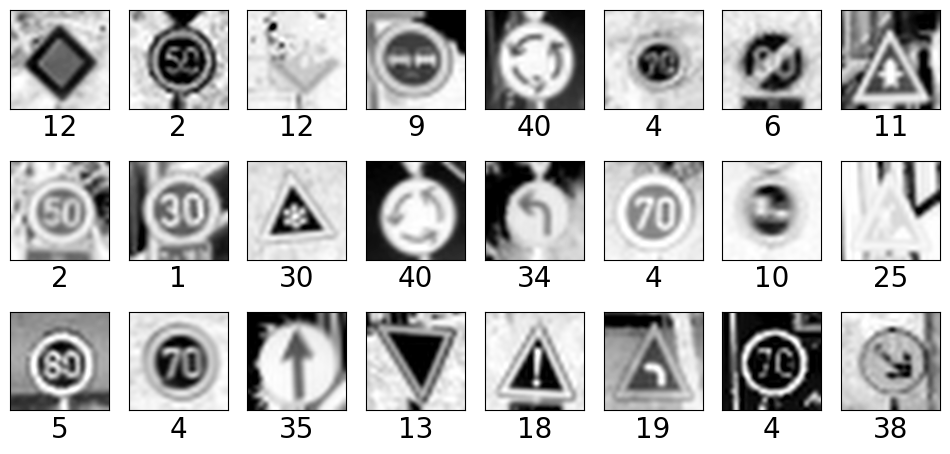


Duration :  00:00:02 548ms


In [40]:
pwk.chrono_start()

dataset='set-24x24-L'
samples=range(24)

with  h5py.File(f'{output_dir}/{dataset}.h5','r') as f:
    x_tmp = f['x_train'][:]
    y_tmp = f['y_train'][:]
    print("dataset loaded from h5 file.")

pwk.plot_images(x_tmp,y_tmp, samples, columns=8, x_size=1.5, y_size=1.5,
                colorbar=False, y_pred=None, cm='binary', save_as='16-enhanced_images')
x_tmp,y_tmp=0,0

pwk.chrono_show()

#Model


In [41]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name  = 'set-48x48-RGB'
batch_size    = 64
epochs        = 20
scale         = 1
fit_verbosity = 1

In [42]:
def read_dataset(enhanced_dir, dataset_name, scale=1):
    '''
    Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:
        x_train,y_train, x_test,y_test data, x_meta,y_meta
    '''

    # ---- Read dataset
    #
    chrono=pwk.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]

    # ---- Rescale
    #
    print('Original shape  :', x_train.shape, y_train.shape)
    x_train,y_train, x_test,y_test = pwk.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)
    print('Rescaled shape  :', x_train.shape, y_train.shape)

    # ---- Shuffle
    #
    x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

    # ---- done
    #
    duration = pwk.chrono_stop()
    size     = pwk.hsize(os.path.getsize(filename))
    print(f'\nDataset "{dataset_name}" is loaded and shuffled. ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- Read dataset
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name, scale)

Original shape  : (3920, 48, 48, 3) (3920,)
Rescaled shape  : (3920, 48, 48, 3) (3920,)

Dataset "set-48x48-RGB" is loaded and shuffled. (137.8 Mo in 0.34811902046203613)


x_train :  (3920, 48, 48, 3)
y_train :  (3920,)
x_test  :  (1263, 48, 48, 3)
y_test  :  (1263,)


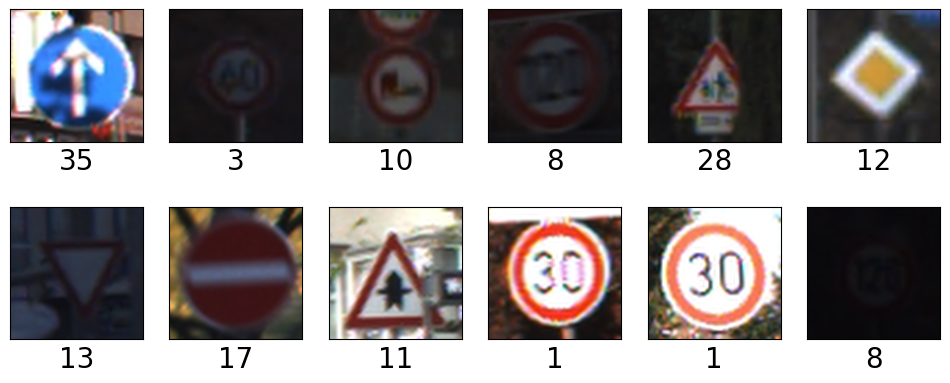

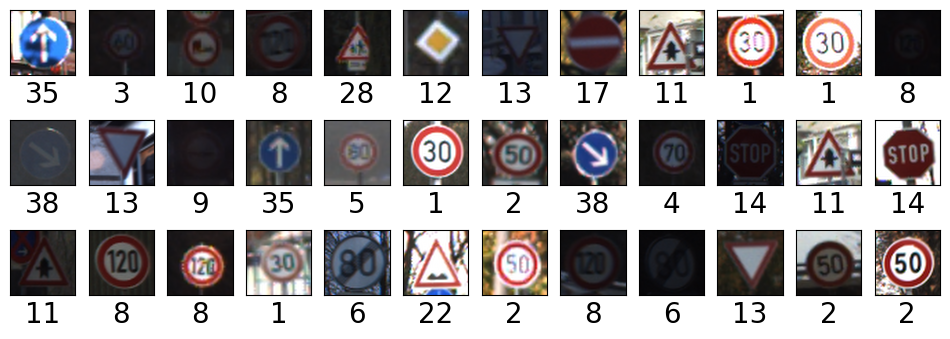

In [43]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

pwk.plot_images(x_train, y_train, range(12), columns=6,  x_size=2, y_size=2, save_as='01-dataset-medium')
pwk.plot_images(x_train, y_train, range(36), columns=12, x_size=1, y_size=1, save_as='02-dataset-small')

In [44]:
# ------------------------------------------------------------------
# -- A simple model, for 24x24 or 48x48 images                    --
# ------------------------------------------------------------------
#
def get_model_01(lx,ly,lz):

    model = keras.models.Sequential()

    model.add( keras.layers.Input((lx,ly,lz)) )

    model.add( keras.layers.Conv2D(96, (3,3), activation='relu' ))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model


# ------------------------------------------------------------------
# -- A more sophisticated model, for 48x48 images                 --
# ------------------------------------------------------------------
#
def get_model_02(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.Input((lx,ly,lz)) )

    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

#Train model


In [45]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (48, 48, 3)


In [46]:
pwk.mkdir('/models')
pwk.mkdir('/logs')

# ---- Callback for tensorboard (This one is homemade !)
#
tenseorboard_callback = TensorboardCallback(
                                log_dir="/logs/tb_" + pwk.tag_now())

# ---- Callback to save best model
#
bestmodel_callback = keras.callbacks.ModelCheckpoint(
                                filepath= "/models/best-model.keras",
                                monitor='val_accuracy',
                                mode='max',
                                save_best_only=True)

# ---- Callback to save model from each epochs
#
savemodel_callback = keras.callbacks.ModelCheckpoint(
                                filepath= "/models/{epoch:02d}.keras",
                                save_freq="epoch")

In [47]:
model = get_model_01(lx,ly,lz)

model.summary()

model.compile(optimizer = 'adam',
              loss      = 'sparse_categorical_crossentropy',
              metrics   = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 96)        2688      
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 96)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 192)       166080    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 192)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 192)       0

In [48]:
chrono=pwk.chrono_start()


# ---- Shuffle train data
x_train,y_train=pwk.shuffle_np_dataset(x_train,y_train)

# ---- Train
history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=fit_verbosity,
                      validation_data=(x_test, y_test),
                      callbacks=[tenseorboard_callback, bestmodel_callback, savemodel_callback] )

model.save('/models/last-model.keras')

pwk.chrono_show()

Epoch 1/20
62/62 [==============================] - 124s 2s/step - loss: 3.2180 - accuracy: 0.1625 - val_loss: 2.3987 - val_accuracy: 0.3547
Epoch 2/20
62/62 [==============================] - 123s 2s/step - loss: 1.9698 - accuracy: 0.4258 - val_loss: 1.7315 - val_accuracy: 0.4513
Epoch 3/20
62/62 [==============================] - 117s 2s/step - loss: 1.3054 - accuracy: 0.5939 - val_loss: 1.1582 - val_accuracy: 0.6508
Epoch 4/20
62/62 [==============================] - 117s 2s/step - loss: 0.8462 - accuracy: 0.7388 - val_loss: 0.8654 - val_accuracy: 0.7427
Epoch 5/20
62/62 [==============================] - 137s 2s/step - loss: 0.5639 - accuracy: 0.8283 - val_loss: 0.7368 - val_accuracy: 0.8092
Epoch 6/20
62/62 [==============================] - 117s 2s/step - loss: 0.4110 - accuracy: 0.8747 - val_loss: 0.6264 - val_accuracy: 0.8401
Epoch 7/20
62/62 [==============================] - 116s 2s/step - loss: 0.3141 - accuracy: 0.9048 - val_loss: 0.6048 - val_accuracy: 0.8345
Epoch 8/20
62

In [49]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9097


In [50]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.5358
Test accuracy  : 0.8852


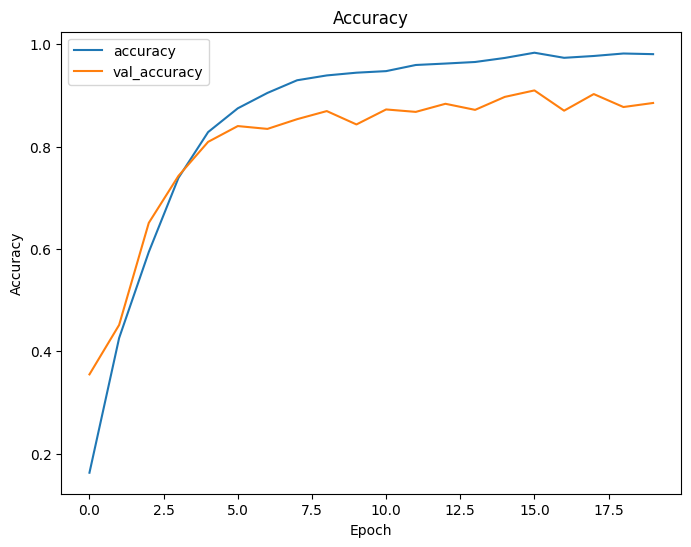

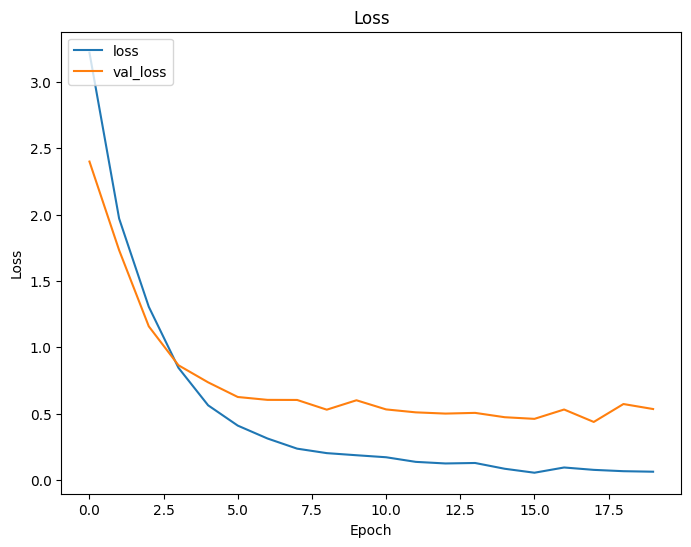

In [51]:
pwk.plot_history(history, save_as='03-history')

In [52]:
loaded_model = keras.models.load_model('/models/best-model.keras')
# loaded_model.summary()
print("Loaded.")

Loaded.


In [58]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.4619
Test accuracy  : 0.9097


In [63]:
def show_prediction( prediction, x, y, x_meta ):

    # ---- A prediction is just the output layer
    pwk.subtitle("Output layer from model is (x100) :")
    with np.printoptions(precision=2, suppress=True, linewidth=95):
        print(prediction*100)

    # ---- Graphic visualisation
    #
    pwk.subtitle("Graphically :")
    plt.figure(figsize=(8,2))
    plt.bar(range(43), prediction[0], align='center', alpha=0.5)
    plt.ylabel('Probability')
    plt.ylim((0,1))
    plt.xlabel('Class')
    plt.title('Trafic Sign prediction')
    pwk.save_fig('05-prediction-proba')
    plt.show()

    # ---- Predict class
    #
    p = np.argmax(prediction)

    # ---- Show result
    #
    pwk.subtitle('In pictures :')
    print("\nThe image :               Prediction :            Real stuff:")
    pwk.plot_images([x,x_meta[p], x_meta[y]], [p,p,y], range(3),  columns=3,  x_size=1.5, y_size=1.5, save_as='06-prediction-images')

    if p==y:
        print("YEEES ! that's right!")
    else:
        print("oups, that's wrong ;-(")

1/1 [==============================] - 0s 45ms/step


<br>**Output layer from model is (x100) :**

[[ 0.31 69.7  16.49  0.09  0.91  0.04  0.    7.69  0.    0.03  0.    0.02  0.    0.02  0.
   0.06  1.88  0.    1.29  0.    0.    0.01  0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.45  0.    0.  ]]


<br>**Graphically :**

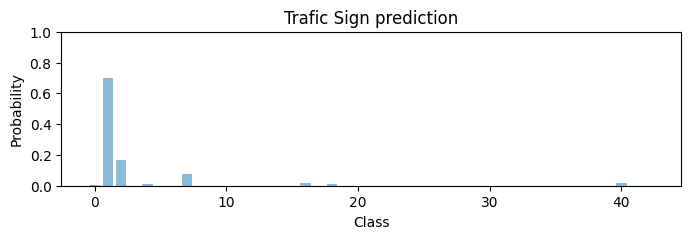

<br>**In pictures :**


The image :               Prediction :            Real stuff:


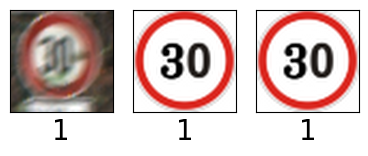

YEEES ! that's right!


In [71]:
# ---- Pick a random image
#
i = random.randint(1,len(x_test))
x,y = x_test[i], y_test[i]

# ---- Do prediction
#
prediction = loaded_model.predict( np.array([x]), verbose=fit_verbosity )

# ---- Show result

show_prediction( prediction, x, y, x_meta )